# variance reduction techniques

## Creating and utilising a wight window to accelerate the deep shielding simulations

This example impletments a single step of the Magic method of weight window generation. The theory of weight windows and the method are best described by the paper here https://scientific-publications.ukaea.uk/wp-content/uploads/Published/INTERN1.pdf

In this tutorial we shall focus on generating a weight window to accelerate the simulation of particles through a shield.

First we must make a model. This is kept as simple as possible as the focus of this notebook is on generating and then using a weight window.

The model is a single sphere of 200 cm radius filled with water and containing a 14MeV point source in the center

In [1]:
import openmc

# creates a shielding material
water = openmc.Material(name='Water')
water.set_density('g/cc', 1.0)
water.add_element('H', 2)
water.add_element('O', 1)
materials = openmc.Materials([water])

sphere1 = openmc.Sphere(r=200, boundary_type='vacuum')

region1 = -sphere1

cell1 = openmc.Cell(fill=water, region=region1)

geometry = openmc.Geometry([cell1])

source = openmc.Source()
source.space = openmc.stats.Point((0.0, 0.0, 0.0))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([14e6], [1.0])
source.particle = 'neutron'

settings = openmc.Settings()
settings.run_mode = 'fixed source'
settings.source = source
settings.particles = 10000
settings.batches = 10

model = openmc.model.Model(geometry, materials, settings)

Now we can plot the simple geometry~

<Figure size 720x720 with 0 Axes>

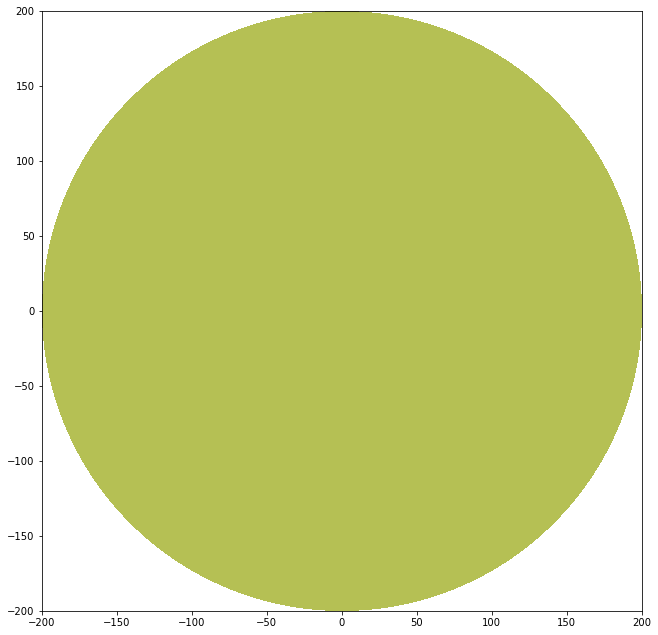

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
model.geometry.root_universe.plot(width=(400, 400), pixels=(600, 600))
plt.show()

Now we shall add a regular mesh tally over the the geometry.

The mesh will be used to record the neutron flux in each mesh voxel

In [3]:
mesh = openmc.RegularMesh()
mesh.lower_left = model.geometry.bounding_box[0]
mesh.upper_right = model.geometry.bounding_box[1]
mesh.dimension = (50, 50, 50)

mesh_filter = openmc.MeshFilter(mesh)

flux_tally = openmc.Tally(name='flux tally')
flux_tally.filters = [mesh_filter]
flux_tally.scores = ['flux']

# adds the mesh tally to the model
model.tallies = [flux_tally]

Now we shall run the simulation and record flux in each mesh voxel

In [4]:
output_file = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Now we can plot the flux and the standard deviation of the flux tally to see how far into the shield the neutrons got. 

/home/jshimwell/openmc_my_fork/openmc/tallies.py:1255: RuntimeWarning: invalid value encountered in true_divide
  data = self.std_dev[indices] / self.mean[indices]


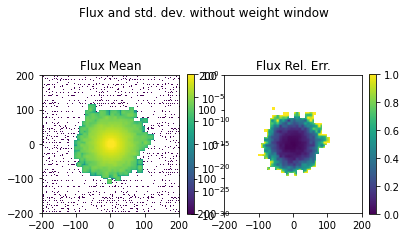

In [5]:
from matplotlib.colors import LogNorm

with openmc.StatePoint(output_file) as sp:
    flux_tally = sp.get_tally(id=flux_tally.id)

llc, urc = model.geometry.bounding_box

fig,  (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Flux and std. dev. without weight window')

slice_index = int(mesh.dimension[-1]/2)

# create a plot of the mean values
flux_mean = flux_tally.mean.reshape(*mesh.dimension)
img1 = ax1.imshow(flux_mean[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]), norm=LogNorm())
ax1.set_title('Flux Mean')
plt.colorbar(img1, ax=ax1, fraction=0.046)
img1.set_clim(vmin=1e-30, vmax=1.0)

# create a plot of the flux relative error
flux_rel_err = flux_tally.get_values(value='rel_err').reshape(*mesh.dimension)
img2 = ax2.imshow(flux_rel_err[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]))
ax2.set_title('Flux Rel. Err.')
plt.colorbar(img2, ax=ax2, fraction=0.046)
# ax2.set_colorbar(img2, ax=ax2)
img2.set_clim(vmin=0.0, vmax=1.0)

plt.show()

As this flux map tells us where the neutrons go we can use it to create a wieght window that promotes neutron transport in areas they normally don't reach.

In [6]:
import openmc_weight_window_generator
# this is a minimal package that adds some functionality to openmc, namely it adds:
# - openmc.StatePoint.generate_wws which we use in this task
# - openmc.Model.generate_wws_magic_method which we use in the next task

sp_file = openmc.StatePoint(output_file)
# this generates an openmc.WeightWindow object from the flux tally
weight_windows = sp_file.generate_wws(tally=flux_tally, rel_err_tol=0.7)

/home/jshimwell/openmc_my_fork/openmc/tallies.py:1255: RuntimeWarning: invalid value encountered in true_divide
  data = self.std_dev[indices] / self.mean[indices]


The weight window generated uses the same mesh as the flux tally, uses the flux to generate lower_ww_bounds, sets the upper_bound_ratio to 5 (rule of thumb used here) and sets the max_split to 1_000_000. These can all be changed to customise the weight window but are reasonable defaults.

We can plot the lower_ww_bounds of the generated weight window to see how it changes over the geometry

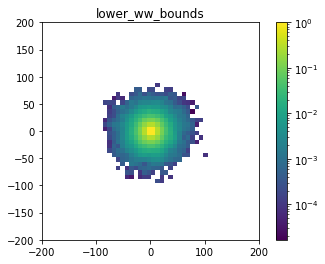

In [7]:
plt.imshow(weight_windows[0].lower_ww_bounds[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]), norm=LogNorm())
plt.title('lower_ww_bounds')
plt.colorbar()

Now we can rerun the simulation but this time using the weight window to push the particles further into the geometry

In [8]:
#deletes the old output files
!rm summary.h5
!rm statepoint.*.h5


model.settings.weight_windows = weight_windows
model.settings.max_split = 1_000_000
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/home/jshimwell/openmc_weight_window_generator/examples/statepoint.10.h5')

We can now plot the flux and standard devation of the flux for the simulation that used weight windows and see that the particles penetrated further into the shield and that the standard deviation has been reduced.

/home/jshimwell/openmc_my_fork/openmc/tallies.py:1255: RuntimeWarning: invalid value encountered in true_divide
  data = self.std_dev[indices] / self.mean[indices]


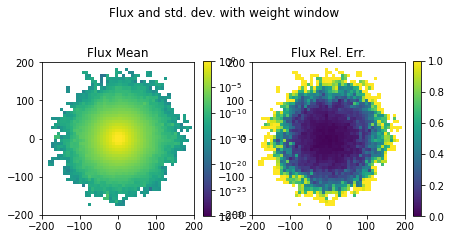

In [9]:
with openmc.StatePoint(output_file) as sp:
    flux_tally = sp.get_tally(id=flux_tally.id)

fig,  (ax1, ax2) = plt.subplots(1,2)
fig.tight_layout() 
fig.suptitle('Flux and std. dev. with weight window')

# create a plot of the mean values
flux_mean = flux_tally.mean.reshape(*mesh.dimension)
img1 = ax1.imshow(flux_mean[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]), norm=LogNorm())
ax1.set_title('Flux Mean')
plt.colorbar(img1, ax=ax1, fraction=0.046)
img1.set_clim(vmin=1e-30, vmax=1.0)

# create a plot of the flux relative error
flux_rel_err = flux_tally.get_values(value='rel_err').reshape(*mesh.dimension)
img2 = ax2.imshow(flux_rel_err[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]))
ax2.set_title('Flux Rel. Err.')
plt.colorbar(img2, ax=ax2, fraction=0.046)
# ax2.set_colorbar(img2, ax=ax2)
img2.set_clim(vmin=0.0, vmax=1.0)

plt.show()

Notice that the particles now get further into the shielding and the error has been reduce across the simulation.

This is not exactly a fair comparison as the second simulation takes a little longer to run. To make it fairer we could use a trigger to stop each simulation after the same amount of time. However that would complicate the example.

Learning Outcomes:
* Weight windows can be useful for accelerating deep shielding simulations where particles
* Weight windows can be generated from a neutron flux field
* The MAGIC method is a popular method of generating weight windows